## LIBRARY IMPORT


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import entropy
import pyhomogeneity as hg
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller, bds
from statsmodels.graphics.tsaplots import plot_acf

In [31]:
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'lines.linewidth': 2,
    'lines.color': 'royalblue',
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titleweight': 'bold',
    'grid.linestyle': '--'
})

In [32]:
df = pd.DataFrame(pd.read_csv("../data/raw/Precipitation_complete.csv"))

## Trend and level

In [33]:
mk_result = mk.original_test(df['precipitation'], alpha=0.01)

# Mann-Kendall test result
trend = mk_result.trend
slope = mk_result.slope
intercept = mk_result.intercept
print(mk_result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.8728592360164749, z=0.1600277227764737, Tau=0.005632930981120396, s=364.0, var_s=5145443.333333333, slope=0.0, intercept=4.0)


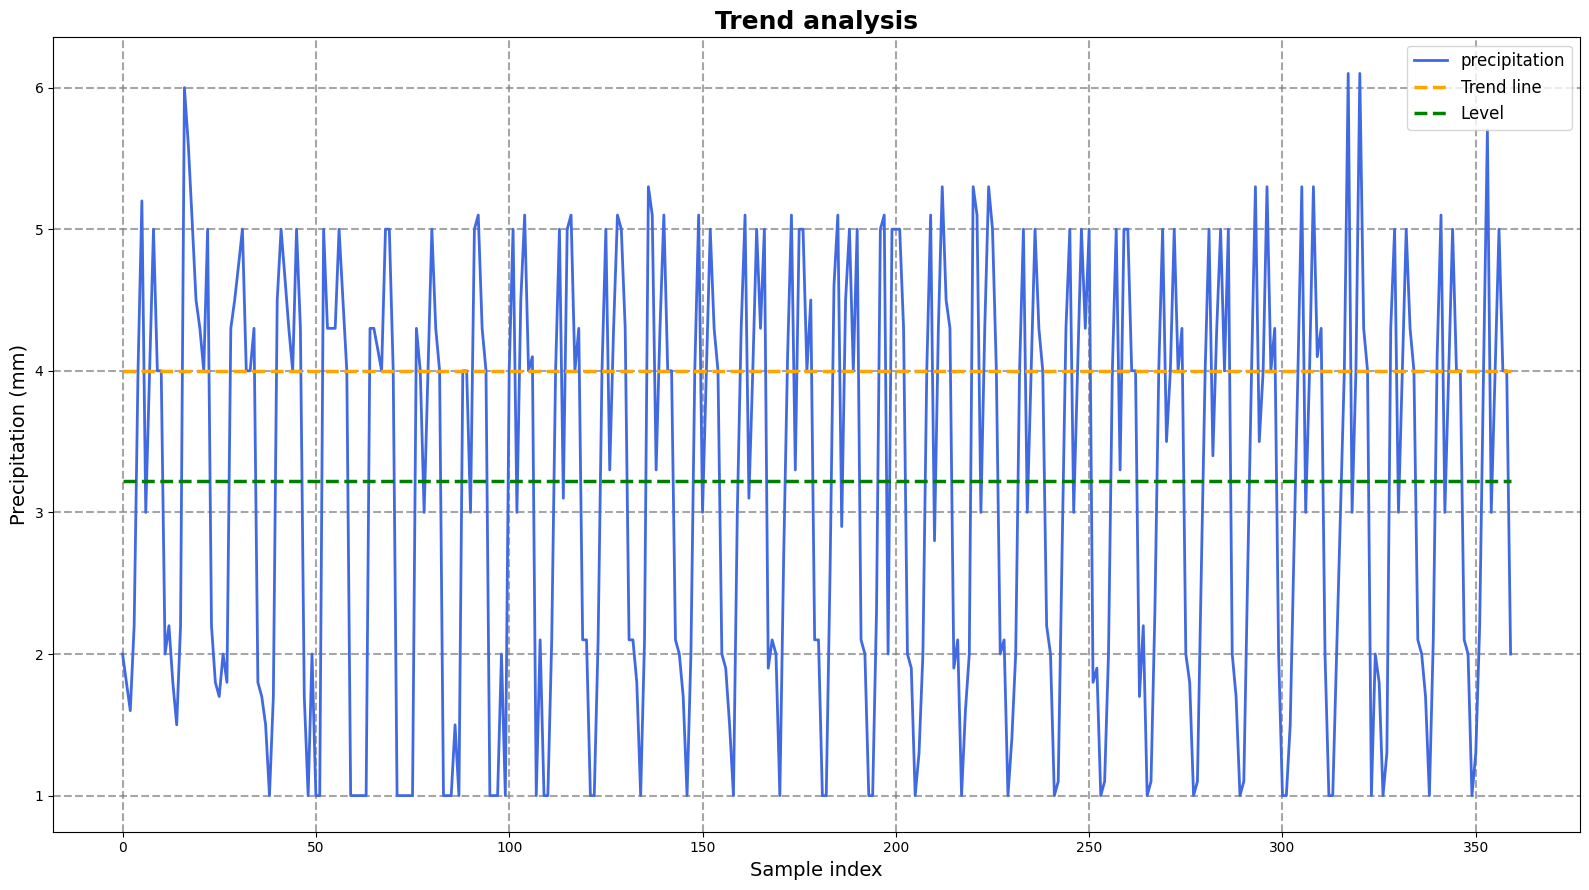

In [34]:
# Calculate the trend line
trend_line = slope * np.arange(len(df)) + intercept
level = np.full(len(df), df['precipitation'].mean())
plt.plot(np.arange(len(df['precipitation'])), df['precipitation'], label='precipitation', color='royalblue')
plt.plot(np.arange(len(df['precipitation'])), trend_line, label='Trend line', color='orange', linestyle='--', lw=2.5)  # Use same x-axis as trend_line
plt.plot(np.arange(len(df['precipitation'])), level, label='Level', color='green', linestyle='--', lw=2.5)  # Use same x-axis

plt.title('Trend analysis', fontsize=18)
plt.xlabel('Sample index', fontsize=14)  # Changed to "Index"
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()


**General Interpretation**:
The test shows that there is no significant trend in the data (`no trend`), the p-value is high, and the slope is `0.0`, which confirms that the values are not significantly increasing or decreasing over time. This indicates stability or absence of a directional pattern in the analyzed time series.


### Seasonality

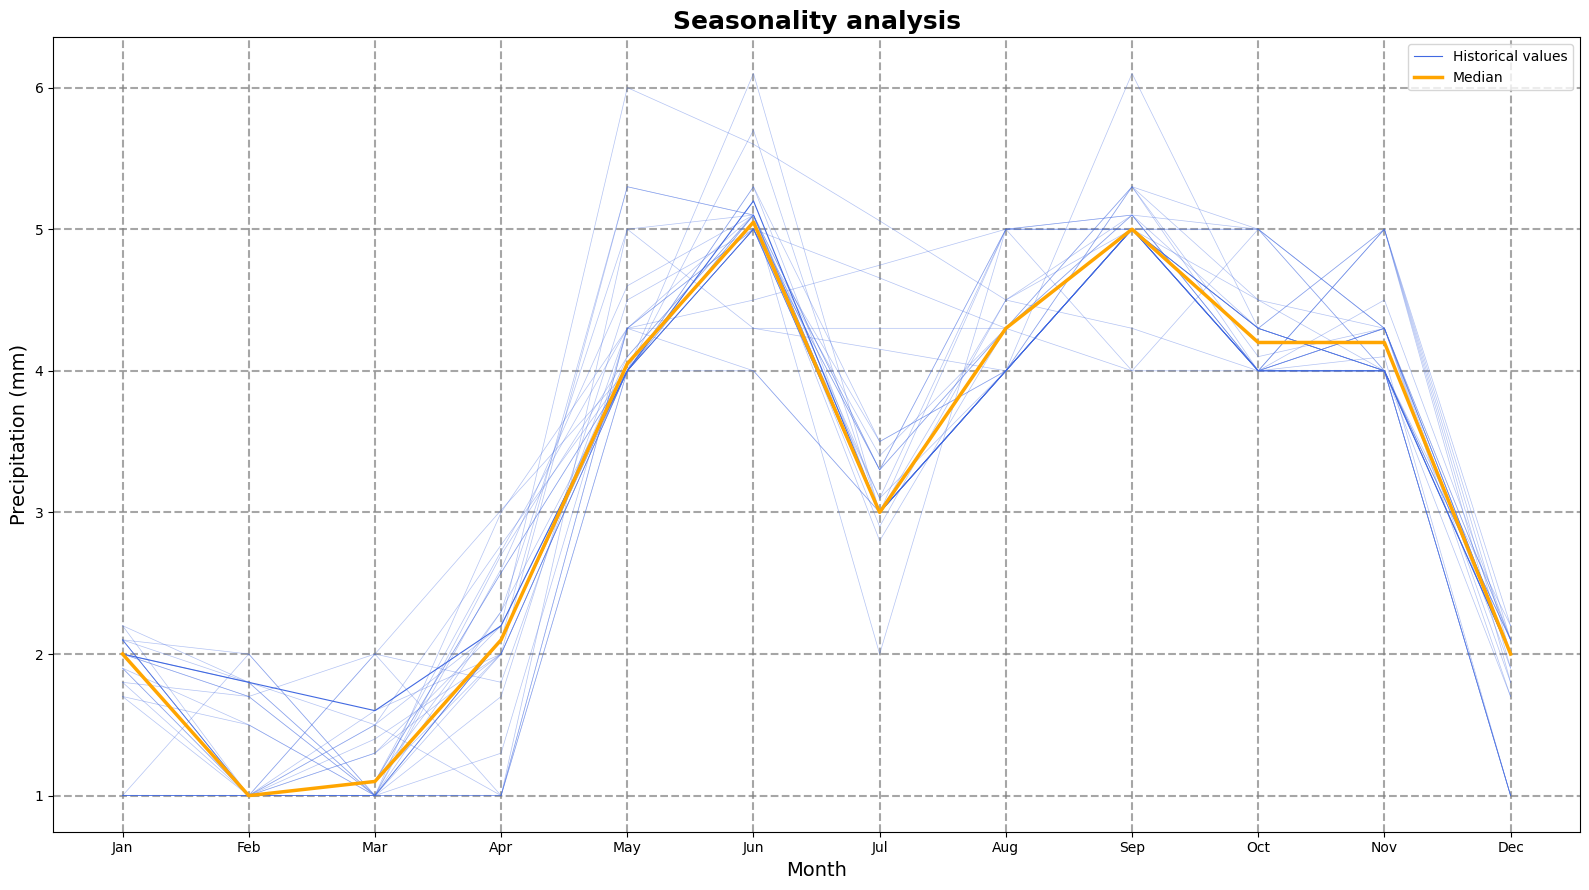

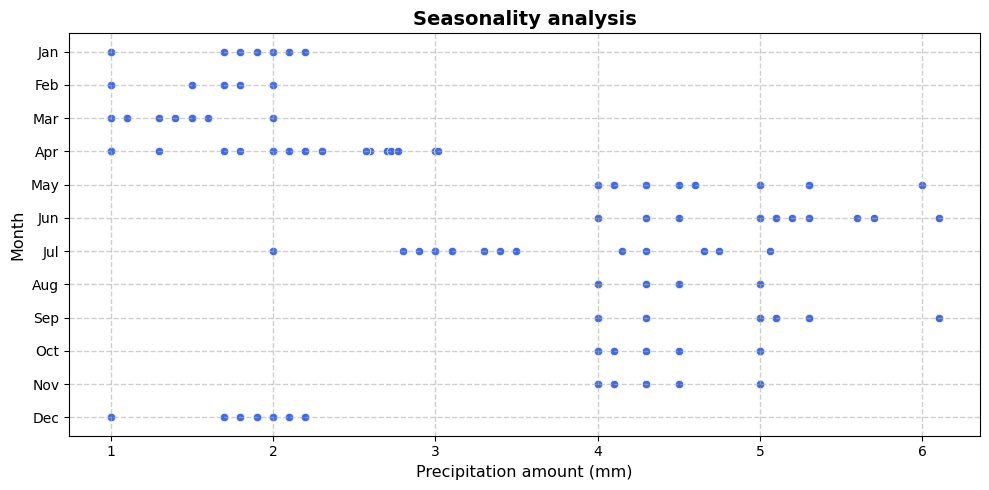

In [35]:
# Calculate the average monthly Precipitation value
monthly_median = df.groupby('month')['precipitation'].median()
years = df['year'].unique()
month_name = df['month_name'].unique()

# First year
first_year = df[df['year'] == years[0]]['precipitation'].values
plt.plot(month_name, first_year, '-', color='royalblue', linewidth=0.8, label='Historical values')

# Following years (1992 onwards)
for year in years[1:]:
    year_data = df[df['year'] == year]['precipitation'].values
    plt.plot(month_name, year_data, '-', color='royalblue', linewidth=0.5, alpha=0.4)

plt.plot(month_name, monthly_median, color='orange', linewidth=2.5, label='Median')

plt.title('Seasonality analysis', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()
plt.legend()
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='precipitation', y='month_name', color='royalblue')
plt.title('Seasonality analysis', fontsize=14)
plt.xlabel('Precipitation amount (mm)').set_fontsize(11.5)
plt.ylabel('Month').set_fontsize(11.5)
plt.tight_layout()
plt.grid(linewidth=1, alpha=0.6)


### Stationarity 


In [54]:
def adf_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            'Lags Number',
            'Number of Observation Used'
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    # Interpretation
    if dftest[1] < 0.01:
        print("We reject the null hypothesis: the series is stationary.")
    else:
        print("The null hypothesis is not rejected: the series has a unit root and is non-stationary.")
adf_test(df['precipitation'])


Results of the Dickey-Fuller Test:
Test Statistic                 -2.368781
p-value                         0.150742
Lags Number                    11.000000
Number of Observation Used    348.000000
Critical Value (1%)            -3.449282
Critical Value (5%)            -2.869881
Critical Value (10%)           -2.571214
dtype: float64
The null hypothesis is not rejected: the series has a unit root and is non-stationary.


**General interpretation**: The null hypothesis that the series has a unit root is not rejected, that is, there is not enough evidence to state that the series is stationary.


### Periodicity


In [37]:
def check_periodicity(df, sample):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)  

    # Calculate the expected date for the next month
    df['Next_month_time'] = df.index + pd.offsets.MonthBegin(1)

    # Calculate the difference excluding the last sample
    df['Difference'] = df['Next_month_time'].shift(1) - df.index

    # Filter non-null differences (excluding the first value which is NaN due to the shift)
    inconsistencies = df[df['Difference'] != pd.Timedelta(0)].dropna(subset=['Difference'])

    if inconsistencies.empty:
        print("All precipitation samples have been taken at 1-month intervals.")
    else:
        print("There are inconsistent time intervals in the precipitation samples.")
        print("Inconsistencies found:")
        print(inconsistencies[['Next_month_time', 'Difference']])
check_periodicity(df, 'precipitation')


There are inconsistent time intervals in the precipitation samples.
Inconsistencies found:
                                            Next_month_time  \
1970-01-01 00:00:00.000000001 1970-02-01 00:00:00.000000001   
1970-01-01 00:00:00.000000002 1970-02-01 00:00:00.000000002   
1970-01-01 00:00:00.000000003 1970-02-01 00:00:00.000000003   
1970-01-01 00:00:00.000000004 1970-02-01 00:00:00.000000004   
1970-01-01 00:00:00.000000005 1970-02-01 00:00:00.000000005   
...                                                     ...   
1970-01-01 00:00:00.000000355 1970-02-01 00:00:00.000000355   
1970-01-01 00:00:00.000000356 1970-02-01 00:00:00.000000356   
1970-01-01 00:00:00.000000357 1970-02-01 00:00:00.000000357   
1970-01-01 00:00:00.000000358 1970-02-01 00:00:00.000000358   
1970-01-01 00:00:00.000000359 1970-02-01 00:00:00.000000359   

                                              Difference  
1970-01-01 00:00:00.000000001 30 days 23:59:59.999999999  
1970-01-01 00:00:00.000000002 30 d

### Homogeneity


SNHT_Test(h=False, cp='1970-01-01', p=0.8106, T=3.1700637890934455, avg=mean(mu1=1.9000000000000001, mu2=3.2353195800331553))


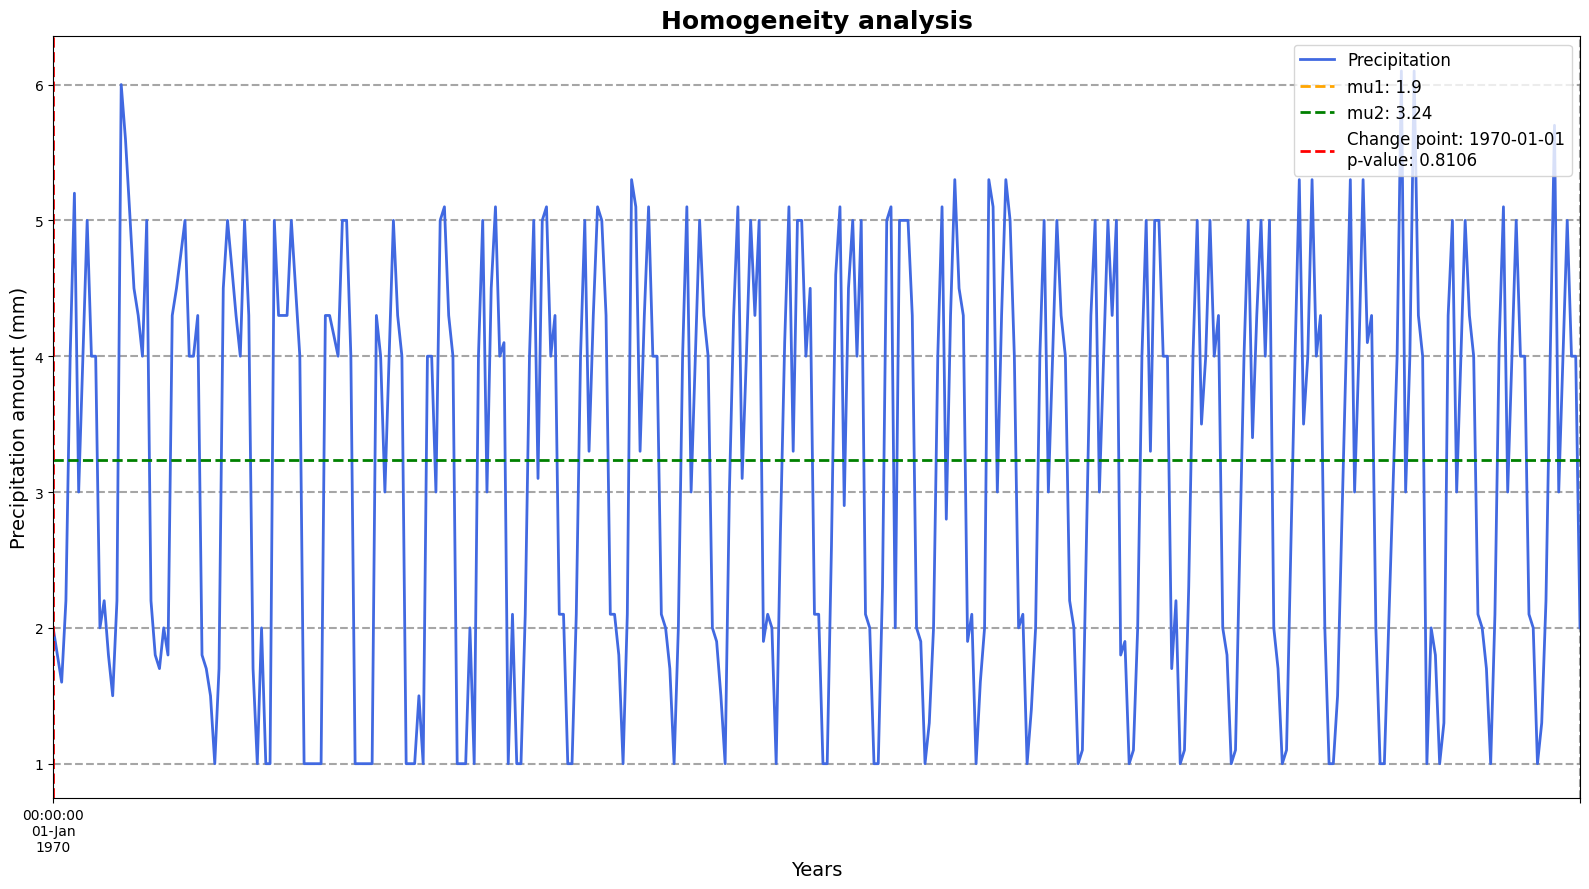

In [56]:
result_snht = hg.snht_test(df['precipitation'])
print(result_snht)
# Get test statistics
loc = result_snht.cp         # Change point date (eg: '1991-04-01')
mu1 = result_snht.avg.mu1    # Average before the change
mu2 = result_snht.avg.mu2    # Average after the change

# Plot the precipitation series
df['precipitation'].plot(label='Precipitation', color='royalblue')

# Horizontal lines (using dates)
plt.hlines(mu1, 
           xmin=df.index.min(),  
           xmax=pd.to_datetime(loc),       
           linestyles='--', lw=2, colors='orange', 
           label=f'mu1: {round(mu1, 2)}')

plt.hlines(mu2, 
           xmin=pd.to_datetime(loc),       
           xmax=df.index.max(),  
           linestyles='--', colors='g', lw=2, 
           label=f'mu2: {round(mu2, 2)}')

# Vertical line of the change point 
plt.axvline(x=pd.to_datetime(loc), 
            linestyle='--', color='red', lw=2,
            label=f'Change point: {loc}\np-value: {result_snht.p}')

plt.title('Homogeneity analysis', fontsize=18)
plt.xlabel('Years')
plt.ylabel('Precipitation amount (mm)')
plt.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()


**General Interpretation:**


Since no statistically significant change was detected in the time series (based on h=False and a high p-value), it can be concluded that the series is homogeneous.


### Non-linearity


Results of the BDS Test:
Test Statistic: 29.095726815260896
p-value: 4.065787252981372e-186
The series is non-linear


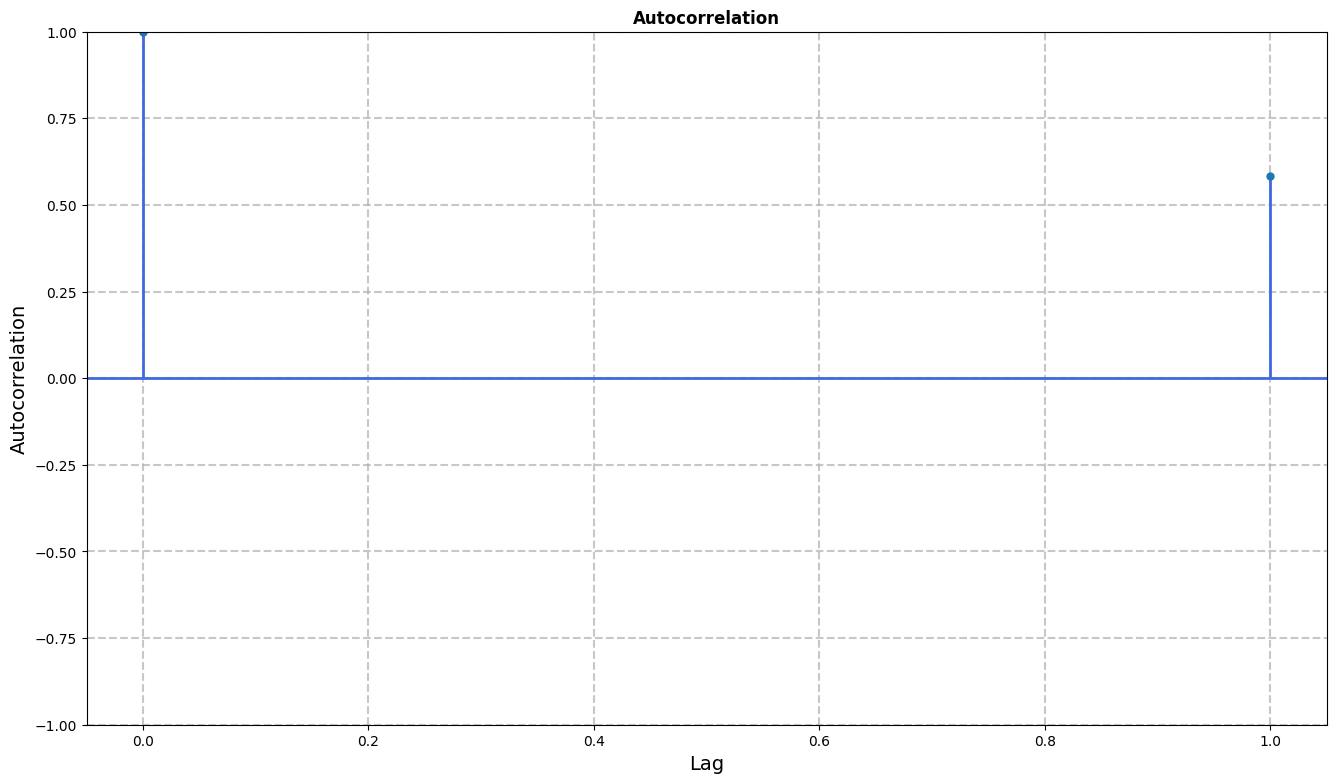

In [39]:
def bds_test(timeseries, alpha):
    print('Results of the BDS Test:')
    dftest = bds(timeseries)
    print(f'Test Statistic: {dftest[0]}')
    print(f'p-value: {dftest[1]}')
    if dftest[1] < alpha:               #compare p-value with significance level 
        print('The series is non-linear') 

bds_test(df['precipitation'], 0.01) #set a significance level of 0.01


### Series complexity: autocorrelation
plot_acf(df['precipitation'], alpha=0.01, lags=1)
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(linewidth=1.5, alpha=0.7)
plt.show()